# Разработка нейросети

## Импорт библиотек

In [2]:
from binance.client import Client
from binance.um_futures import UMFutures
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient
from binance.lib.utils import config_logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import keys
import time
import math
import random
from datetime import datetime
from pytz import timezone
import logging
import requests
import json
import re
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None # отключение  предупреждения
pd.set_option('display.max_columns', None) # показывать максимальное количесвто столбцов

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Загрузка локальных данных

In [4]:
df = pd.read_csv('ds_tot_5_step.csv')

In [5]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std,target
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,3061.0,19713.0,9,4,311.1,9662.5,0.0,9647.5,966.3,6624.4,-0.000900
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,27194.0,11165.0,7,7,7858.2,5775.6,5904.5,4357.0,7986.6,3538.8,-0.001675


In [6]:
('Размерность загруженного датасета:', df.shape)

('Размерность загруженного датасета:', (78987, 33))

### Удаление признаков

In [7]:
df.columns

Index(['mid_price', 'ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10', 'bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10', 'imbalance_vol',
       'ask_max', 'bid_max', 'max_ask_level', 'max_bid_level', 'asks_mean',
       'bids_mean', 'asks_median', 'bids_median', 'asks_std', 'bids_std',
       'target'],
      dtype='object')

In [8]:
features = ['ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10', 'bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10', 'imbalance_vol',
       'ask_max', 'bid_max', 'max_ask_level', 'max_bid_level', 'asks_mean',
       'bids_mean', 'asks_median', 'bids_median', 'asks_std', 'bids_std',
       'target']

In [9]:
df = df[features]

In [10]:
df.head(2)

,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std,target
0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,3061.0,19713.0,9,4,311.1,9662.5,0.0,9647.5,966.3,6624.4,-0.000900
1,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,27194.0,11165.0,7,7,7858.2,5775.6,5904.5,4357.0,7986.6,3538.8,-0.001675


## ML

### Разделение дата-сета

In [11]:
train, test = train_test_split(df, test_size=0.25, shuffle=False, random_state= 12)
print('Размерность train:', train.shape)
print('Размерность test:', test.shape)

Размерность train: (59240, 32)
Размерность test: (19747, 32)


In [122]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']
print('Размерность X_train:', X_train.shape)
print('Размерность y_train:', y_train.shape)
print('Размерность X_test:', X_test.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (59240, 31)
Размерность y_train: (59240,)
Размерность X_test: (19747, 31)
Размерность y_test: (19747,)


### Масштабирование признаков

In [123]:
num_features = X_train.columns 

In [124]:
scaler = StandardScaler()

In [125]:
scaler.fit(X_train[num_features]);

In [126]:
X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features]);

In [127]:
display(X_train.head(2))
display(X_test.head(2))

,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
25797,-0.327209,-0.141186,0.020245,0.902380,0.880074,0.363050,-0.308424,-0.390156,-0.068205,-0.046103,-0.089958,-0.028373,0.131201,-0.058516,-0.060906,0.301169,0.140253,-0.212181,-0.194728,0.060619,-0.149046,-0.289173,-0.140335,-1.447689,0.941001,0.137972,-0.06382,0.698001,0.216748,-0.250561,-0.144761
75964,0.754582,2.319821,2.974580,0.700736,0.143903,-0.009501,0.464325,-0.026062,0.252949,4.252517,0.085997,0.481255,0.101103,0.220163,0.511059,0.194654,-0.362815,0.141266,0.174501,0.193866,-0.548116,2.153099,-0.081652,0.894243,0.941001,2.086992,0.36220,1.640075,1.087686,1.799474,-0.119591


,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
18403,0.374929,0.098336,-0.220438,0.068645,-0.374177,0.181898,-0.002000,-0.734428,-0.451190,0.977776,-0.089958,-0.148755,-0.174866,-0.161049,-0.576753,-0.553979,-0.353055,-0.138785,-0.026641,1.873527,0.237147,0.186059,0.658091,0.894243,0.941001,-0.051264,0.229925,-0.258710,-0.720163,0.065539,0.622455
24596,-0.397753,-0.474454,-0.500884,-0.666973,-0.723958,-0.871325,-0.826386,-0.869748,-0.811218,-0.569371,-0.089958,-0.477667,-0.174866,-0.249300,-0.766163,-0.867869,-0.864930,-0.277878,-0.298202,-0.269230,0.587729,-0.743266,-0.285605,0.894243,0.941001,-1.265650,-0.802254,-1.321867,-1.294813,-0.761172,-0.256256


Вывод: масштабирование признаков выполено.

### Dummy Regressor

Получим предсказания от константной модели, от чего впоследствии будем отталкиваться.

In [128]:
Dummy_regressor = DummyRegressor(strategy='mean')

In [129]:
Dummy_regressor.fit(X_train, y_train)

DummyRegressor()

In [130]:
Dummy_regressor_predict = Dummy_regressor.predict(X_test)

In [131]:
MAE_Dummy_regressor = mean_absolute_error(y_test, Dummy_regressor_predict)

In [132]:
print('MAE константной модели:', round(MAE_Dummy_regressor, 5))

MAE константной модели: 0.00285


### Random Forest

In [133]:
RandomForest = RandomForestRegressor(random_state= 12)

In [134]:
param_RS_RandomForest={'max_depth':list(np.arange(2, 100, step=5)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [ ]:
R_Search_RandomForest = RandomizedSearchCV(RandomForest, param_RS_RandomForest, n_iter=5, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)

In [151]:
%%time
model_RF = R_Search_RandomForest.fit(X_train, y_train)
print(model_RF.best_params_)
print(model_RF.best_score_)

{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 210}
-0.0028256197093446023
CPU times: total: 43.3 s
Wall time: 15min 5s


In [152]:
MAE_RandomForest = model_RF.best_score_.round(5)

In [153]:
print('MAE_RandomForest:', MAE_RandomForest)

MAE_RandomForest: -0.00283


Вывод: RandomForest не превысил качество константной модели.

### Catboost

In [139]:
CatBoost = CatBoostRegressor(random_state=12,
                              verbose=0,
                              cat_features = None)
                              #task_type = device_for_Catboost)

In [140]:
param_RS_CatBoost = {'depth':list(np.arange(1, 16, step=2)),
              'learning_rate':np.arange(0.01, 0.3, step=0.05),
              'n_estimators':np.arange(100, 1000, step=50),
              'l2_leaf_reg':np.arange(2, 30, step=1)
         }

In [141]:
R_Search_CatBoost = RandomizedSearchCV(CatBoost, param_RS_CatBoost, n_iter=5, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)

In [142]:
%%time
model_Cb = R_Search_CatBoost.fit(X_train, y_train)
print(model_Cb.best_params_)
print(model_Cb.best_score_)

{'n_estimators': 400, 'learning_rate': 0.01, 'l2_leaf_reg': 24, 'depth': 3}
-0.0028252307986645886
CPU times: total: 14.6 s
Wall time: 3min 12s


In [144]:
MAE_CatBoost = model_Cb.best_score_.round(5)

In [145]:
print('MAE_CatBoost:', MAE_CatBoost)

MAE_CatBoost: -0.00283


Вывод: CatBoost не превысил качество константной модели.

### Важность признаков

In [146]:
feature_importances = pd.DataFrame({'features': X_test.columns,'feature_importance':model_Cb.best_estimator_.feature_importances_});
display(feature_importances.sort_values('feature_importance',ascending=False).head(32))

,features,feature_importance
10,bid_1,15.943039
1,ask_2,10.736521
27,asks_median,7.829807
3,ask_4,7.802581
0,ask_1,5.929331
25,asks_mean,4.672057
14,bid_5,4.537952
9,ask_10,4.345808
4,ask_5,3.711203
2,ask_3,3.361011


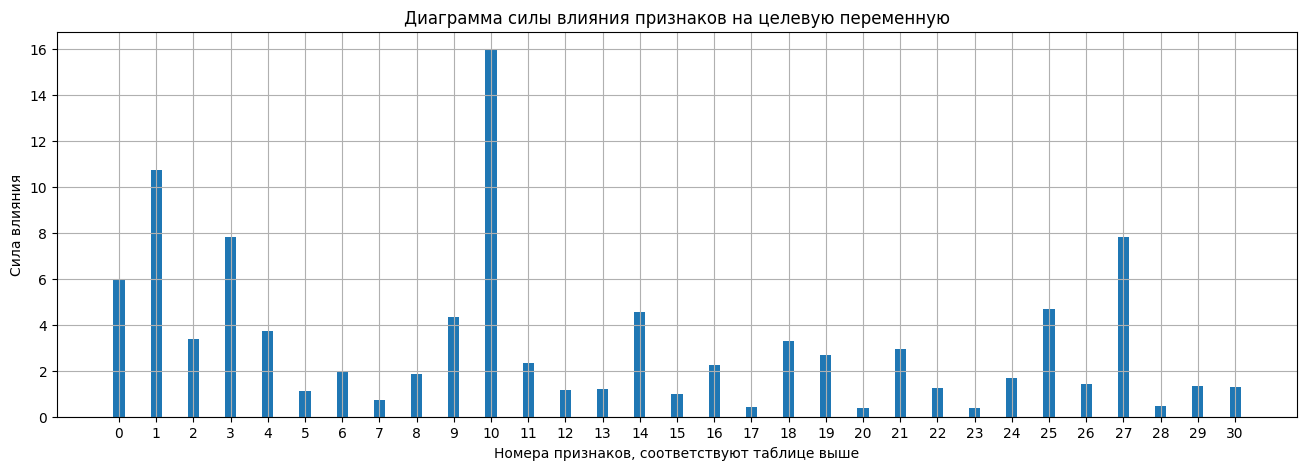

In [149]:
plt.figure(figsize = (16,5))
plt.title('Диаграмма силы влияния признаков на целевую переменную')
plt.xlabel('Номера признаков, соответствуют таблице выше')
plt.ylabel('Сила влияния')
plt.bar(feature_importances.index, feature_importances['feature_importance'], width = 0.3)
plt.xticks(feature_importances.index)
plt.grid()
plt.show();

Вывод: большее значение имеют биды и аски находящиеся ближе к спреду. Дальше 5 уровня брать не имеет смысла.

### Net

#### Разделение датасета

In [36]:
train_net, df_50 = train_test_split(df, test_size=0.5, random_state= 12)
valid_net, test_net = train_test_split(df_50, test_size=0.5, random_state= 12)
print('Размерность train:', train_net.shape)
print('Размерность valid:', valid_net.shape)
print('Размерность test:', test_net.shape)

Размерность train: (39493, 33)
Размерность valid: (19747, 33)
Размерность test: (19747, 33)


In [37]:
X_train_net = train_net.drop('target', axis=1)
y_train_net = train_net['target']
X_valid_net = valid_net.drop('target', axis=1)
y_valid_net = valid_net['target']
X_test_net = test_net.drop('target', axis=1)
y_test_net = test_net['target']
print('Размерность X_train_net:', X_train_net.shape)
print('Размерность y_train_net:', y_train_net.shape)
print('Размерность X_valid_net:', X_valid_net.shape)
print('Размерность y_valid_net:', y_valid_net.shape)
print('Размерность X_test_net:', X_test_net.shape)
print('Размерность y_test_net:', y_test_net.shape)

Размерность X_train_net: (39493, 32)
Размерность y_train_net: (39493,)
Размерность X_valid_net: (19747, 32)
Размерность y_valid_net: (19747,)
Размерность X_test_net: (19747, 32)
Размерность y_test_net: (19747,)


#### Масштабирование признаков

In [38]:
scaler_net = StandardScaler()

In [39]:
scaler_net.fit(X_train_net[num_features]);

In [40]:
X_train_net[num_features] = scaler_net.transform(X_train_net[num_features])
X_valid_net[num_features] = scaler_net.transform(X_valid_net[num_features])
X_test_net[num_features] = scaler_net.transform(X_test_net[num_features]);

In [41]:
display(X_train_net.head(2))
display(X_valid_net.head(2))
display(X_test_net.head(2))

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
53174,-0.774928,-0.146457,0.152701,-0.318943,-0.613981,-0.490766,-0.678448,-0.171913,-0.193271,0.161263,0.209402,-0.323233,-0.489124,-0.146333,-0.634353,-0.748857,-0.871899,-0.708682,-0.276632,-0.799268,-0.292520,-1.332118,-0.274561,-0.352184,0.892764,0.939994,-0.341056,-0.907390,-0.663450,-1.296668,-0.185452,-0.337642
76748,-1.115874,-0.426598,0.060516,-0.249013,0.441795,0.404095,0.761782,1.023664,1.118156,2.067992,0.503710,-0.323233,-0.489124,0.082504,-0.277077,-0.200343,-0.120796,0.216836,-0.088403,0.135724,0.359261,-0.557592,0.692392,0.021523,0.425549,0.939994,1.316348,0.059777,1.787615,0.271641,0.736807,0.004615


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
50051,-0.376488,0.642461,0.065929,0.842160,1.870425,0.908867,-0.270574,-0.408161,-0.428089,0.432069,4.876719,0.083035,-0.275603,-0.128894,-0.352413,-0.080443,1.051017,0.357409,0.067786,-0.169071,-0.222735,-0.734126,2.544566,-0.058308,0.892764,-0.900521,1.731646,-0.014090,0.551598,0.131166,2.336095,-0.043984
73530,-0.861525,-0.433465,-0.453001,-0.480279,-0.229578,-0.478584,-0.294687,0.037103,0.922753,-0.273471,-0.175826,0.385756,1.978724,0.239514,0.566364,1.421650,2.012310,0.931891,0.063368,0.543871,0.190954,0.806479,0.030523,0.129390,-0.041666,-0.900521,-0.198161,1.171179,-0.278505,2.270043,0.026610,0.000344


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,ask_max,bid_max,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
78157,-1.095526,-0.433465,-0.340708,-0.491173,-0.066201,0.374017,-0.030345,0.072156,-0.433171,0.071853,0.216802,-0.323233,-0.489124,-0.057889,0.032600,-0.010701,-0.105647,-0.332041,0.306986,-0.566882,-0.084091,-0.095321,-0.270092,-0.054386,0.892764,0.019737,-0.103954,-0.169783,0.244403,0.017782,-0.182921,-0.078666
17834,1.329658,-0.433465,-0.486411,-0.491173,-0.628295,-0.735339,-0.864464,-0.820037,-0.638614,-0.738953,-0.716200,0.037682,0.848766,0.260838,-0.055369,0.431630,0.365120,0.063064,-0.118248,0.046340,0.069356,1.550674,-0.833639,-0.144698,0.892764,0.939994,-1.220551,0.276459,-1.297788,1.155999,-0.810052,-0.189644


#### Тензоры

In [42]:
X_train_tz = torch.FloatTensor(X_train_net.values).to(device)
y_train_tz = torch.FloatTensor(y_train_net.values).to(device)
X_valid_tz = torch.FloatTensor(X_valid_net.values).to(device)
y_valid_tz = torch.FloatTensor(y_valid_net.values).to(device)
X_test_tz = torch.FloatTensor(X_test_net.values).to(device)
y_test_tz = torch.FloatTensor(y_test_net.values).to(device)

In [43]:
print('Расмерность X_train_tz:', X_train_tz.shape)
print('Расмерность y_train_tz:', y_train_tz.shape)
print('Расмерность X_valid_tz:', X_valid_tz.shape)
print('Расмерность y_valid_tz:', y_valid_tz.shape)
print('Расмерность X_test_tz:', X_test_tz.shape)
print('Расмерность y_test_tz:', y_test_tz.shape)

Расмерность X_train_tz: torch.Size([39493, 32])
Расмерность y_train_tz: torch.Size([39493])
Расмерность X_valid_tz: torch.Size([19747, 32])
Расмерность y_valid_tz: torch.Size([19747])
Расмерность X_test_tz: torch.Size([19747, 32])
Расмерность y_test_tz: torch.Size([19747])


#### Кол-во нейронов входного и выходного слоя

In [44]:
n_in_neurons, n_out_neurons = X_train_net.shape[1], 1 
print(n_in_neurons)
print(n_out_neurons)

32
1


#### Функция потерь

In [45]:
loss = nn.MSELoss()

#### Архитектура сети

In [177]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        #self.act1 = nn.ELU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)

        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.uniform_(self.fc1.bias, a=-3, b=0)
        
    def forward(self, x):
        x = self.fc1(x)
        #x = self.act1(x)

        x = self.fc2(x)
        
        return x   

In [47]:
loss_value_current = []
MAE_current = []
Net(X_train_net.shape[1], 300, n_out_neurons).to(device)
net = Net(X_train_net.shape[1], 300, n_out_neurons).to(device)

In [158]:
def run_net(model, num_epochs, learning_rate):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    epoch = 0
    epoch_end = 0
    MAE = 0
    MAE_best = math.inf
    R_2_best = -100
    
    while True:
        if (epoch <= num_epochs): # and (MAE <= MAE_best):
            epoch += 1
            optimizer.zero_grad()
            preds = model.forward(X_train_tz).flatten().to(device)
            loss_value = loss(preds, y_train_tz)
            loss_value.backward()
            optimizer.step()
            if epoch % 10 == 0:
                model.eval()
                test_preds = model.forward(X_valid_tz).to(device)
                pred = test_preds.cpu().detach().numpy()
                MAE = mean_absolute_error(y_valid_net, pred)
                R_2 = r2_score(y_valid_net, pred)
                
                loss_value_current.append(loss_value.cpu().detach().numpy())
                MAE_current.append(MAE)
                
                if MAE < MAE_best:
                    MAE_best = MAE
                    epoch_end = epoch
                    R_2_best = R_2
        
                print('Функция потерь ===>', loss_value)
                print('MAE === > ', MAE)
                print('Эпоха === > ', epoch)
                print('R_2 === > ', R_2)
                print('------------------------------------------------------------------------------------')
        
        else:
            break
            
    return (
        print('MAE_best:', MAE_best),
        print('R_2_best:', R_2_best),
        print('Эпоха с лучшим MAE:', epoch_end)
    )

In [159]:
NUM_EPOCHS = 1500

In [160]:
loss_value_current = []
MAE_current = []
Net(n_in_neurons, 300, n_out_neurons).to(device)
net = Net(n_in_neurons, 300, n_out_neurons).to(device)
run_net(net, NUM_EPOCHS, 0.01)

Функция потерь ===> tensor(3.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  1.3529212202786447
Эпоха === >  10
R_2 === >  -134134.83661605403
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.7535, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.7703922362910169
Эпоха === >  20
R_2 === >  -47854.74218903505
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.2639, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.21171913029190517
Эпоха === >  30
R_2 === >  -5760.124857960886
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.17773873321246467
Эпоха === >  40
R_2 === >  -3959.928892858483
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0272

(None, None, None)

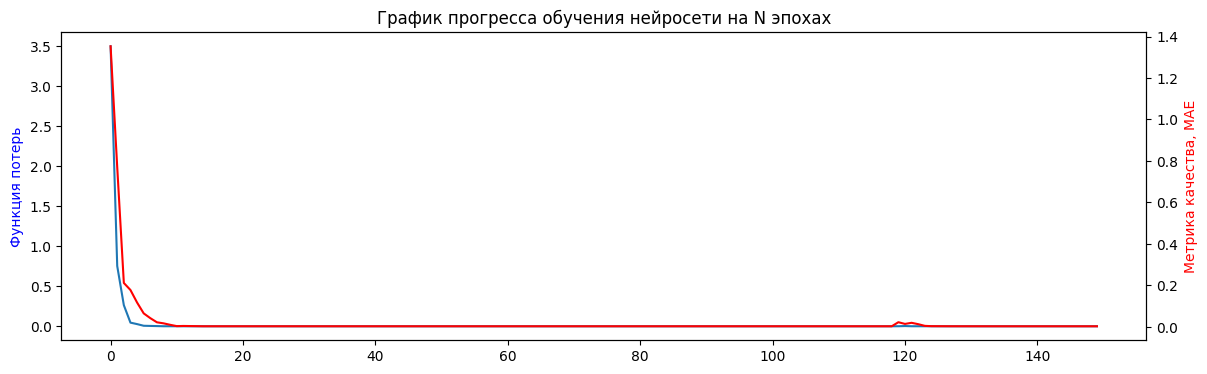

In [161]:
x1, y1 = list(range(len(loss_value_current))), loss_value_current # функция потерь
x2, y2 = list(range(len(MAE_current))), MAE_current             # метрика качества
fig, ax1 = plt.subplots(figsize = (14,4))
ax2 = ax1.twinx()
ax1.plot(x1, y1)
ax2.plot(x2, y2, color='red')
ax1.set_ylabel('Функция потерь', color='blue')
ax2.set_ylabel('Метрика качества, MAE', color='red')
plt.title('График прогресса обучения нейросети на N эпохах')
plt.xlabel('Эпохи, тыс')
plt.show();

Нейросеть обучается, но дает прогнозы соответствующие среднему значению целевого признака (R2 близко к 0).

#### Подбор архитектуры сети

Подберём количество нейронов в скрытом слое:

In [52]:
num_neyrons =  [20,50,100,200,300,400,500,800,1000,1500,2000, 2500, 3000]  
learning_rate_list = np.arange(0.01, 0.1, step=0.01)             

In [ ]:
for n_hidden_neurons_1 in num_neyrons:
    learning_rate_ = random.choice(learning_rate_list)
    Net(X_train.shape[1], n_hidden_neurons_1, 1).to(device)
    net = Net(X_train.shape[1], n_hidden_neurons_1, 1).to(device)
    print(f'При кол-ве нейронов в скрытом слое: { n_hidden_neurons_1}, learning_rate: {learning_rate_}')
    run_net(net, 3000, learning_rate_)
    print('--------------------------------------------------------------------------------')

При кол-ве нейронов в скрытом слое: 20, learning_rate: 0.09
MAE_best: 0.002828502174334575
R_2_best: 0.00476499543790232
Эпоха с лучшим MAE: 570
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 50, learning_rate: 0.08
MAE_best: 0.002833736860092697
R_2_best: 0.007887370060242649
Эпоха с лучшим MAE: 2380
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 100, learning_rate: 0.09
MAE_best: 0.002834112529644427
R_2_best: 0.007901240699321965
Эпоха с лучшим MAE: 3000
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 200, learning_rate: 0.01
MAE_best: 0.0028336440706949457
R_2_best: 0.008292120907238854
Эпоха с лучшим MAE: 2330
--------------------------------------------------------------------------------
При кол-ве нейронов в скрытом слое: 300, learning_rate: 0.05
MAE_best: 0.00283554277205

Увеличение количества нейронов в скрытом слое не улучшило метрики.

Создадим сеть с большим количеством скрытых слоев

In [172]:
n_neurons = [n_in_neurons, 50, 100, 200, 100, 50]
net_layers = []

In [173]:
for i in range(1, len(n_neurons) - 1):
		net_layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))

		if (i+1) % 2 == 0:
			net_layers.append(nn.BatchNorm1d(n_neurons[i])) #  для чётных слоёв
		else:
			net_layers.append(nn.Dropout(random.choice(np.arange(0.1, 0.5, step=0.1)))) # Dropout для нечетных	

net_layers.append(nn.Linear(n_neurons[-2], n_out_neurons))	

In [174]:
net_2 = nn.Sequential(*net_layers).to(device)

In [175]:
print(net_2)

Sequential(
  (0): Linear(in_features=32, out_features=50, bias=True)
  (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=50, out_features=100, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=200, bias=True)
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=100, out_features=1, bias=True)
)


In [176]:
run_net(net_2, NUM_EPOCHS, 0.01)

Функция потерь ===> tensor(0.1676, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.28619342147621846
Эпоха === >  10
R_2 === >  -13287.386541875298
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0988, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.2582079487186676
Эпоха === >  20
R_2 === >  -12082.91256062062
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.03840273878273923
Эпоха === >  30
R_2 === >  -266.3080085090849
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)
MAE === >  0.02103272931759462
Эпоха === >  40
R_2 === >  -166.77936374718368
------------------------------------------------------------------------------------
Функция потерь ===> tensor(0.00

(None, None, None)

Вывод: эксперименты с архитектурой не улучшили качество нейросети.

#### Предсказание на тесте

In [184]:
net_2.eval()
test_Net = net_2.forward(X_test_tz).to(device)
pred_net = test_Net.cpu().detach().numpy()
MAE_Net = round(mean_absolute_error(y_test_net, pred_net), 5)

In [185]:
print('MAE нейросети:', MAE_Net)

MAE нейросети: 0.00286


## Вывод:

In [186]:
predicts_models = [MAE_Dummy_regressor, MAE_RandomForest, MAE_CatBoost, MAE_Net]

In [187]:
data = {'model': ['Dummy_regressor', 'RandomForest', 'Catboost', 'Net'], 'MAE': predicts_models} 

In [188]:
result_total = pd.DataFrame(data)
result_total

,model,MAE
0,Dummy_regressor,0.002845
1,RandomForest,-0.002830
2,Catboost,-0.002830
3,Net,0.002860


Вывод: ни одна из моделей не показала удовлетворительный результат. Вероятная причина - слишком большая задержка при сборе данных снимков стакана.